# (Mono-)Transiting planets

The way in which the Keplerian function is parameterized in **kima** is most
useful for RV detection, but can in some cases become a bottleneck. 

One such case is when a planet is observed to transit only one or two times, the
so-called mono-transits or duo-transits. Here, the orbital period is uncertain
but the time of transit is known relatively well, and so the standard
parameterization in \($ P, K, e, M_0, \omega $\), which is used for the
`known_object` as well, is not ideal. 

<div class="admonition note">
    <div class="admonition-title">Note</div>
    <p style="margin-top: 1em">
        The (old) work-around of using the <code>Gaussian_from_Tc</code> prior for \(M_0\)
        will not help in cases like this.
    </p>
</div>

To allow for this corner case, a new `transiting_planet` mode has been added.
This is much alike the `known_object`, except that the Keplerian is
parameterized directly in terms of \($P, K, e, \omega, T_c$\). In this way,
independent priors can be assigned to these parameters.

Let's see an example.

### Simulating a dataset

First, we get some standard imports out of the way

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import kima

We'll create a function to generate a simple RV dataset containing a planet. We
_define_ the time of periastron and then _calculate_ the time of conjunction
from it. To make things interesting, we remove a few data points so that the
orbit is slightly harder to constrain.

In [2]:
def create_data():
    np.random.seed(43) # to be reproducible

    # random times and uncertainties
    t = np.sort(np.random.uniform(0, 100, 57))
    err = np.random.uniform(0.1, 0.3, t.size)

    # define orbital parameters
    P, K, e, w = 30, 2, 0.6, 0.1
    # define time of periastron
    Tp = 15
    # use the time of first observation as "epoch"
    M0_epoch = t[0]
    # mean anomaly at the epoch
    M0 = 2 * np.pi * (M0_epoch - Tp) / P

    # calculate the time of conjunction
    f = np.pi/2 - w
    E = 2 * np.arctan(np.tan(f/2) * np.sqrt((1-e)/(1+e)))
    Tc = Tp + P/(2*np.pi) * (E - e*np.sin(E))

    # simulate a Keplerian function
    v = kima.keplerian(t, P, K, e, w, M0, M0_epoch)
    # and add some small Gaussian noise
    v += np.random.normal(loc=0.0, scale=0.05, size=t.size)

    # remove some points to make things interesting
    t = t[v < 1]
    err = err[v < 1]
    v = v[v < 1]

    return (t, v, err), P, K, Tp, e, w, M0, M0_epoch, Tc

In [3]:
(t, v, err), P, K, Tp, e, w, M0, M0_epoch, Tc = create_data()

Let's plot the data together with the true Keplerian model

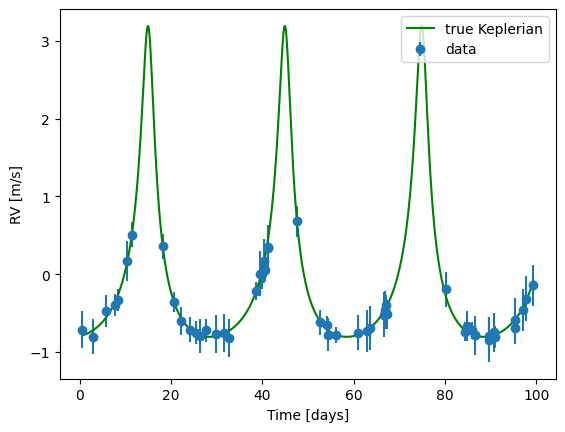

In [4]:
tt = np.linspace(t[0], t[-1], 1000)
vv = kima.keplerian(tt, P, K, e, w, M0, M0_epoch)

fig, ax = plt.subplots()
ax.errorbar(t, v, err, fmt='o', label='data')
ax.plot(tt, vv, color='g', label='true Keplerian')
ax.legend()
ax.set(xlabel='Time [days]', ylabel='RV [m/s]');

### A simple fit

Let's now fit these data, assuming only that we know there is one Keplerian signal

In [5]:
from kima import RVData, RVmodel, distributions

data = RVData(t, v, err)
model = RVmodel(fix=True, npmax=1, data=data)

# since we didn't simulate any jitter, let's just assume it's zero
model.Jprior = distributions.Fixed(0.0)

Run the model for a few thousand steps

In [6]:
kima.run(model, steps=30_000, num_threads=4)

and now load the results

In [6]:
res1 = kima.load_results(model)

log(Z) = 13.876939900974554
Information = 16.97202651128454 nats.
Effective sample size = 4131.119355475683


100%|██████████| 4131/4131 [00:00<00:00, 24176.37it/s]


Plotting a few posterior samples together with the data already shows that we
didn't recover the true Keplerian signal very well

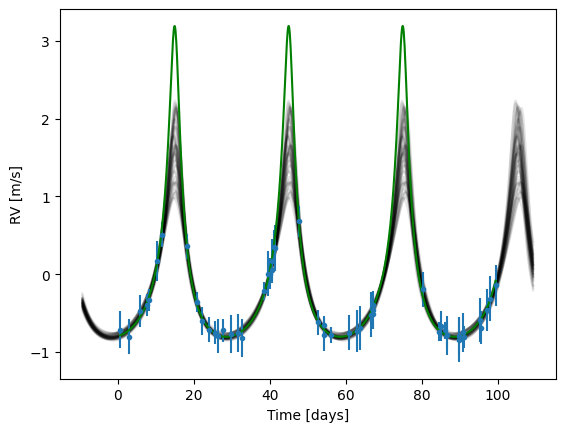

In [7]:
fig = res1.plot_random_samples(legend=False)
fig.axes[0].plot(tt, vv, color='g');

and indeed the posteriors for the orbital parameters show that, while the period
was recovered, the semi-amplitude and eccentricity are a bit off from the true values

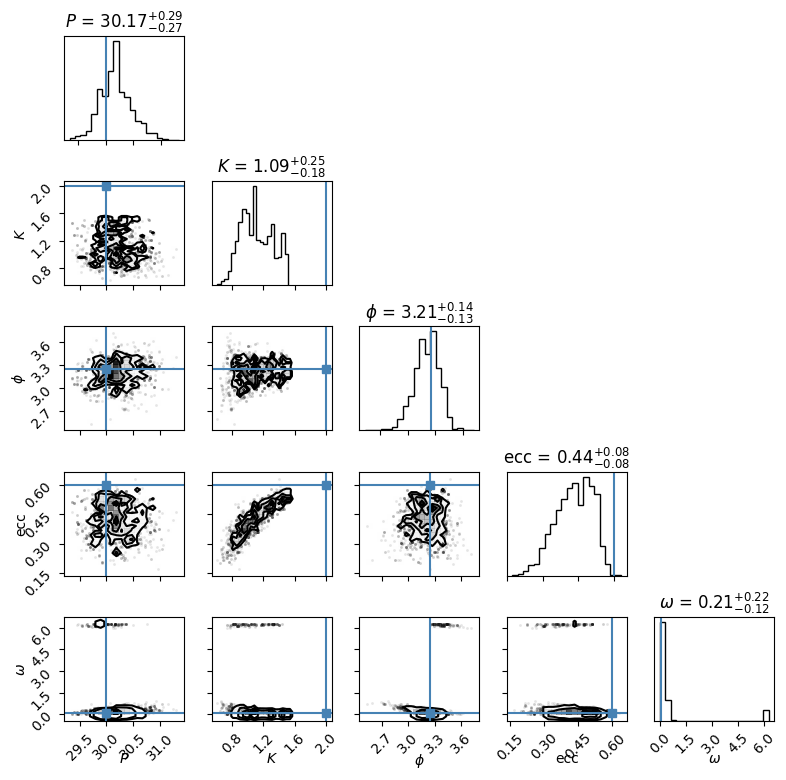

In [10]:
res1.corner_planet_parameters(true_values=[P, K, M0+2*np.pi, e, w]);

### Assuming $T_c$ is known

In our convoluted example, we do have information about the time of conjunction
$T_c$. If we assume we don't know the orbital period, then we are basically in a
similar situation to a mono-transit or a duo-transit.

Let's fit the data again with a model that uses one _transiting planet_,
allowing us to assign a prior to $T_c$ directly.

In [12]:
#same as before
data = RVData(t, v, err)

# no 'normal' Keplerians, as we'll use a 'transiting planet'
model = RVmodel(fix=True, npmax=0, data=data)

# same as before
model.Jprior = distributions.Fixed(0.0)

# assume there is one planet
model.set_transiting_planet(1)
# set standard priors (same as before)
model.TR_Pprior = [distributions.LogUniform(1.0, data.get_timespan())]
model.TR_Kprior = [distributions.Uniform(0.0, 5*data.get_RV_span())]
model.TR_eprior = [distributions.Uniform(0, 1)]
model.TR_wprior = [distributions.UniformAngle()]
# but for Tc, use the known value
model.TR_Tcprior = [distributions.Gaussian(Tc, 1e-3)]

Let's run the model again

In [13]:
kima.run(model, steps=30_000, num_threads=4)

In [14]:
res2 = kima.load_results(model)

log(Z) = 15.620712644328114
Information = 16.053040966880445 nats.
Effective sample size = 4121.815081323306


100%|██████████| 4121/4121 [00:00<00:00, 32222.62it/s]


and now the true Keplerian signal is much better recovered

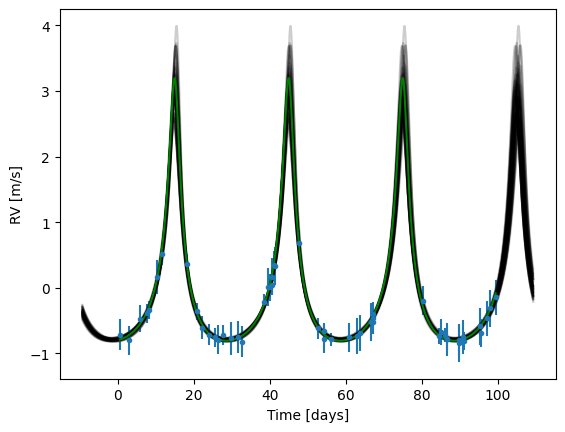

In [15]:
fig = res2.plot_random_samples(legend=False)
fig.axes[0].plot(tt, vv, color='g');

The posteriors for the orbital parameters (of the _transiting planet_) show that
just by setting a prior on $T_c$, we are now able to recover the true values of
the semi-amplitude and eccentricity

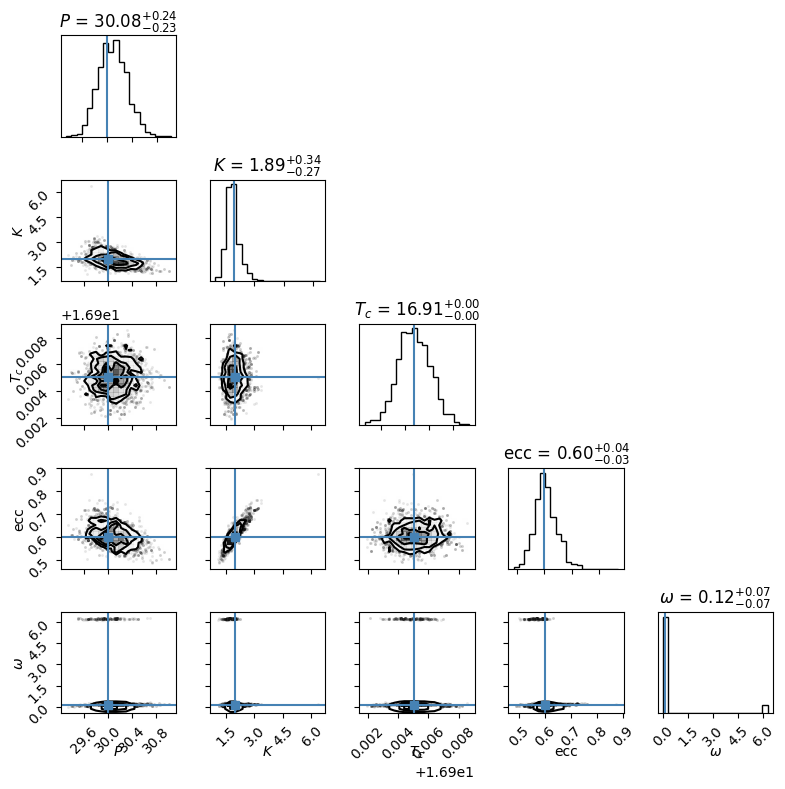

In [18]:
res2.corner_planet_parameters(true_values=[P, K, Tc, e, w],
                              include_transiting_planet=True);

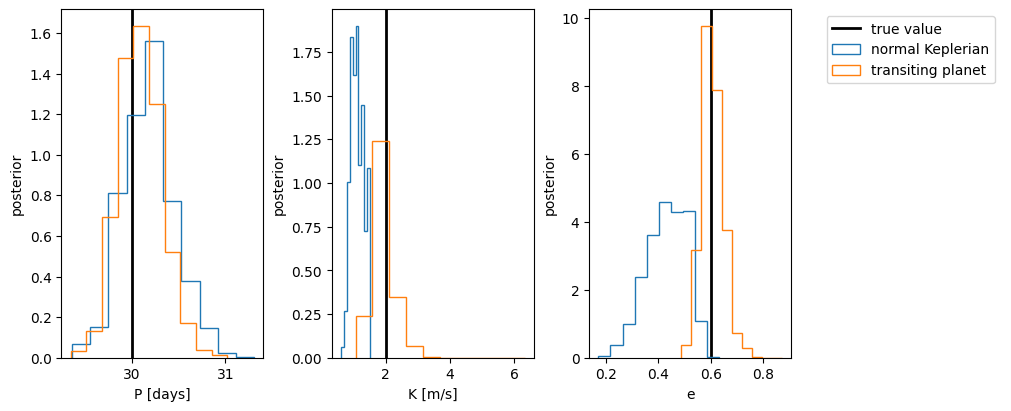

In [19]:
_, axs = plt.subplots(1, 4, constrained_layout=True, figsize=(10, 4))

axs[0].axvline(P, color='k', lw=2, label='true value')
axs[1].axvline(K, color='k', lw=2, label='true value')
axs[2].axvline(e, color='k', lw=2, label='true value')

kw = dict(density=True, histtype='step')

for r in [res1, res2]:
    if hasattr(r, 'TR') and r.TR:
        axs[0].hist(r.TRpars[:, 0], **kw, label='transiting planet')
        axs[1].hist(r.TRpars[:, 1], **kw, label='transiting planet')
        axs[2].hist(r.TRpars[:, 3], **kw, label='transiting planet')
    else:
        axs[0].hist(r.posteriors.P.ravel(), **kw, label='normal Keplerian')
        axs[1].hist(r.posteriors.K.ravel(), **kw, label='normal Keplerian')
        axs[2].hist(r.posteriors.e.ravel(), **kw, label='normal Keplerian')

axs[0].set(xlabel='P [days]', ylabel='posterior')
axs[1].set(xlabel='K [m/s]', ylabel='posterior')
axs[2].set(xlabel='e', ylabel='posterior')
axs[3].legend(*axs[0].get_legend_handles_labels())
axs[3].axis('off');